In [447]:
%matplotlib inline
import chainer
from chainer import optimizers, cuda, serializers
import chainer.functions as F
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
import time
import datetime
from net import Net, MLP

In [448]:
n_epoch = 50000 #エポック
batchsize = 5000 #バッチサイズ
printout_interval = 1000 #何エポック毎に誤差をプリントアウトするか

bprop_len = 100 #何回でバックプロパゲーションを打ち切るか(trancate)
n_units = 20 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = True #GPUを使うかどうか

In [449]:
xp = cuda.cupy if use_gpu is True else np

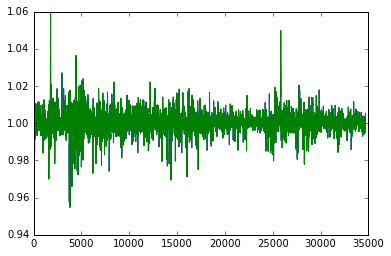

In [450]:
raw_data = []
f = open('nikkei5min.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    if row[7] == "":
        continue
    raw_data.append(row[7])
raw_data = np.asarray(raw_data, dtype=np.float32)
data_x = raw_data[:-1]
data_y = raw_data[1:]
train_data_x, test_data_x = data_x[:int(len(data_x) * 0.8)], data_x[:int(len(data_x) * 0.2)]
train_data_y, test_data_y = data_y[:int(len(data_y) * 0.8)], data_y[:int(len(data_y) * 0.2)]

plt.plot(train_data_x)
plt.plot(train_data_y)

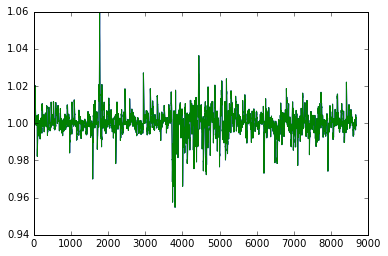

In [451]:
plt.plot(test_data_x)
plt.plot(test_data_y)

In [452]:
#ネットワークを試す関数
def evaluate(model, x, y):
    evaluator = model.copy()
    evaluator.reset_state()
    out = evaluator.predict(x)
    error = F.mean_squared_error(out, y)
    return chainer.cuda.to_cpu(out.data), error.data

In [453]:
model = Net(1, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
test_loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
x_cache = []
y_cache = []
x_chainer_variable = chainer.Variable(xp.asarray([[x] for x in train_data_x], dtype=np.float32))
y_chainer_variable = chainer.Variable(xp.asarray([[y] for y in train_data_y], dtype=np.float32))
test_data_x_chainer_variable = chainer.Variable(xp.asarray([[x] for x in test_data_x], dtype=np.float32))
test_data_y_chainer_variable = chainer.Variable(xp.asarray([[y] for y in test_data_y], dtype=np.float32))
prev_time = time.time()
for i in range(jump * n_epoch):
    if len(x_cache) <= i % jump:
        x_cache.append( chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs])))
        y_cache.append( chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs])))
    x = x_cache[i % jump]
    y = y_cache[i % jump]
    #x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    #y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % printout_interval == 0:
            now = time.time()
            elapsed_time = now - prev_time
            prev_time = now
            speed = printout_interval / elapsed_time
            eta = datetime.timedelta(seconds = (n_epoch - epoch) / speed)
            eta = datetime.timedelta(seconds = eta.seconds)
            print('epoch {0}, error {1}, {2:.2f} epoch/s, eta {3}'.format(epoch, loss_data * len(x) / length, speed, eta))
        loss.append(evaluate(model, x_chainer_variable, y_chainer_variable)[1])
        test_loss.append(evaluate(model, test_data_x_chainer_variable, test_data_y_chainer_variable)[1])
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 1000, error 4.370942115783691, 63.00 epoch/s, eta 0:12:57
epoch 2000, error 0.019222553819417953, 64.31 epoch/s, eta 0:12:26
epoch 3000, error 0.001988595351576805, 64.34 epoch/s, eta 0:12:10
epoch 4000, error 0.001886149519123137, 60.93 epoch/s, eta 0:12:34
epoch 5000, error 0.0018540351884439588, 64.31 epoch/s, eta 0:11:39
epoch 6000, error 0.0018418842228129506, 64.26 epoch/s, eta 0:11:24
epoch 7000, error 0.0018364955903962255, 64.26 epoch/s, eta 0:11:09
epoch 8000, error 0.0018328578444197774, 49.79 epoch/s, eta 0:14:03
epoch 9000, error 0.0018294933252036572, 64.17 epoch/s, eta 0:10:38
epoch 10000, error 0.0018260390497744083, 64.18 epoch/s, eta 0:10:23
epoch 11000, error 0.0018224356463178992, 64.16 epoch/s, eta 0:10:07
epoch 12000, error 0.0018186914967373013, 64.19 epoch/s, eta 0:09:51
epoch 13000, error 0.001814810442738235, 64.28 epoch/s, eta 0:09:35
epoch 14000, error 0.0018107930663973093, 64.40 epoch/s, eta 0:09:18
epoch 15000, error 0.001806640182621777, 64.34 epoc

In [454]:
#モデルを保存
serializers.save_npz('my.model', model)

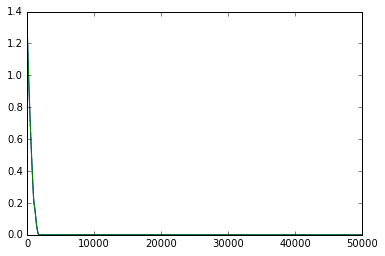

In [455]:
plt.plot(loss)
plt.plot(test_loss)

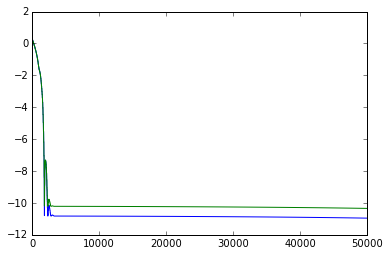

In [456]:
plt.plot([math.log(x) for x in loss])
plt.plot([math.log(x) for x in test_loss])

In [457]:
output, error = evaluate(model, x_chainer_variable, y_chainer_variable)

print(error)

1.746425732562784e-05


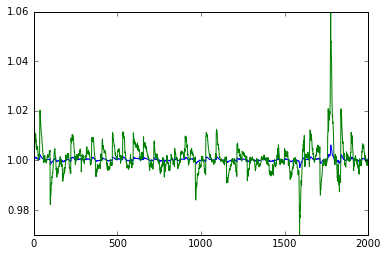

In [458]:
plt.plot(output[:2000])
plt.plot(train_data_y[:2000])

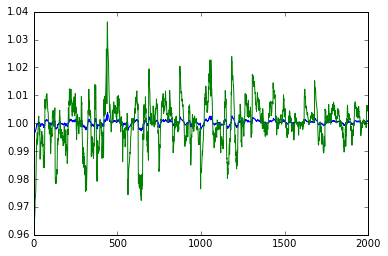

In [459]:
plt.plot(output[4000:6000])
plt.plot(train_data_y[4000:6000])

In [460]:
output, error = evaluate(model, test_data_x_chainer_variable, test_data_y_chainer_variable)
print('test error = {}'.format(error))

test error = 3.216281038476154e-05


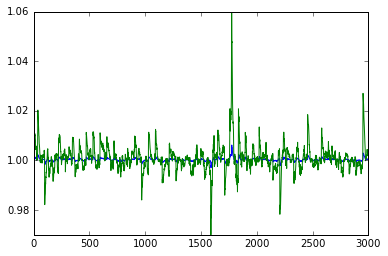

In [461]:
plt.plot(output[:3000])
plt.plot(test_data_y[:3000])